<a href="https://colab.research.google.com/github/asadimtiazmalik/Deep-Regression-Techniques-for-Decoding-Dark-Matter-with-Strong-Gravitational-Lensing-/blob/main/Deep_Regression_Techniques_for_Decoding_Dark_Matter_with_Strong_Gravitational_Lensing_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Exploring the Dataset**

Following code cell extracts all the data from the `tar.gz` file.

In [1]:
!tar -xvf '/content/drive/MyDrive/data.tgz'

Streaming output truncated to the last 5000 lines.
data/image_140466812021761890849935117392024097947.npy
data/image_214454232775476126858435938728675756697.npy
data/image_130801378814327756070396393793485679451.npy
data/image_311893850764781353709529115536192378408.npy
data/image_282165301331939040711285061265397272591.npy
data/image_21440908318479958144560759949570839926.npy
data/image_14246263583378039485404972992679267669.npy
data/image_14159338952001522610968069444327016917.npy
data/image_136653021479910190046378102527256138307.npy
data/image_332932571917593010534093958031892783820.npy
data/image_270111698154078866315002421949443996447.npy
data/image_141276881797963724247841965871917381705.npy
data/image_189348898416623356872431659680862005654.npy
data/image_2066840381301645643610836490276655881.npy
data/image_309460885844656250230861071645143094921.npy
data/image_258134283852911782251417926629741928725.npy
data/image_178762768427299605340851784625807099718.npy
data/image_30301588

In [12]:
# Importing Python Libraries 
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing Pytorch Libraries 
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split



In [3]:
# Downgrading numpy to read .npy images
#!pip install numpy==1.16.2
#import numpy as np
print(np.__version__)

1.16.2


The function `load_images` loads all the data from `.npy` files to the lists `images` and `masses`.

In [4]:
def load_images(folder):
  images = []
  masses = []
  for filename in os.listdir(folder):
      if filename.endswith('.npy'):
          img, mss = np.load(os.path.join(folder,filename))
          image = img.astype(np.float32)
          mass  = np.float32(mss)
          images.append(image)
          masses.append(mass)

  return images, masses

The dataset is extracted from the directory `content/data`. It contains one folder, containing (25000 images). Each of these images is a `.npy` file that contain an image and a value for the `sub-halo` mass. Let's extract this information using `load_images`.

In [5]:
folder = '/content/data'
images, masses = load_images(folder)

Let's look at a sample image from the dataset. Each image has a dimension as `150 x 150 x 1`. It can be inferred that the images are all grayscale.

43.69419


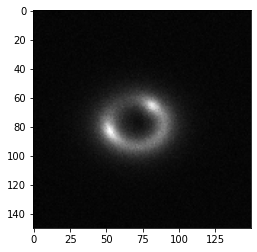

In [6]:
plt.imshow(images[50], cmap='gray')
print(masses[50])

In [8]:
img = images[0]
img.shape

(150, 150)

The data from the two lists is transferred to a dataframe with `images` saved in one column and `masses` saved in the other.

In [9]:
df = pd.DataFrame(dtype=np.float32)
df['images'] = images
df['masses'] = masses
df.head()

images      masses
0  [[32.0, 31.0, 23.0, 39.0, 29.0, 27.0, 31.0, 31...  350.156036
1  [[23.0, 29.0, 29.0, 25.0, 31.0, 27.0, 29.0, 26...  236.937820
2  [[35.0, 35.0, 36.0, 24.0, 35.0, 23.0, 36.0, 31...  328.625671
3  [[29.0, 30.0, 27.0, 36.0, 33.0, 38.0, 25.0, 39...  335.543365
4  [[26.0, 32.0, 25.0, 15.0, 31.0, 37.0, 31.0, 27...  329.504333

In [10]:
df['masses'] = df['masses'].astype(np.float32)
df.dtypes

images     object
masses    float32
dtype: object

# **Data preprocessing**



## **Normalizing the features and targets**

In order to help our network train better it's important to perform some normalization on the data available.

In [71]:
df['masses']=(df['masses']-df['masses'].min())/(df['masses'].max()-df['masses'].min())

In [9]:
df['images']=df['images']/255

In [9]:
df.dtypes

images     object
masses    float32
dtype: object

## **Train - Test Split** 

Lets split our data into test and train. I am using the 90-10 split for train and test data. We have 25000 images of which 10% (2500 images) are for test data and 90% (22500 images) are for train data.

In [11]:
# 90% train - test split
train_df = df.iloc[:22500,:]
test_df = df.iloc[22500:,:]

print(train_df.shape)
print(test_df.shape)

(22500, 2)
(2500, 2)


Since I am using a Dataframe object to store the dataset. I have made a class `MyDataset` that will upload this information to a Pytorch Dataset. That will be further used to populate the `Dataloader`. To perform that I'll use a map style dataset from `torch.utils.data.Dataset`. This will iterate over the entire Dataframe and fill in the `Dataset` object.

In [19]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        return (
            T.functional.rotate(torchvision.transforms.functional.normalize(torchvision.transforms.functional.to_tensor(row['images']), [0.5],[0.5]),90.0),
            row["masses"],
        )

dataset = MyDataset(train_df)

The length of our `Dataset` is coherent with the `train_df` length.

In [20]:
len(dataset)

22500

# **Train and Validation Datasets**

Since there's no predefined validation set, we can set aside a small portion (5000 images) of the training set to be used as the validation set. I have used the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, I have also set a seed for the random number generator.

In [21]:
random_seed = 42
torch.manual_seed(random_seed);

In [22]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(17500, 5000)

In [23]:
from torch.utils.data.dataloader import DataLoader

batch_size = 64

In [24]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)

# **Defining the Model**

## **Setting up the Loss Function**
The class `ImageClassificationBase()` is responsible for computing the loss during validation and training steps and logging that value. What I planned was to get a vector from the Convolutional Layers and see how far that is from the original mass value. The loss obtained will be used to train the weights for the model. 

The loss I used for this problem is `MSELoss`. Since we are dealing with a regression problem the MSE Loss can help train the model better and give a more favourable outcome.

In [25]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        image, mass = batch 
        out = self(image)           # Generate predictions
        L = nn.MSELoss()            # Calculate loss
        loss = L(out, mass)
        return loss
    
    def validation_step(self, batch):
        image, mass = batch 
        out = self(image)                    # Generate predictions
        L = nn.MSELoss()                     # Calculate loss
        loss = L(out, mass)
        acc = accuracy(out, mass)            # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.8f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, mass):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == mass).item() / len(preds))

## **Convolutional Model**

The strategy I have used to solve this problem is setting up a Convolutional Neural Network followed by a Linear Layer. Here I have used 4 Convolutional Layers that convolve the input vector from `1 x 150 x 150` to `150 x 9 x 9`. Each Convolutional Layer contains 2 `nn.Conv2d` that are activated by `nn.Relu` or `Rectified Linear Unit` and at the end of each Convolutional Layer I have used a `nn.MaxPool2d` layer. Following the convolutional layers is a `nn.Flatten` layer that outputs a `1 - dimensional` vector. This goes through a `nn.Linear` layer and outputs a single value. 

In [26]:
class Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 75 x 75

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 37 x 37 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 18 x 18

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 9 x 9

            nn.Flatten(), 
            nn.Linear(512*9*9, 1024),
            nn.ReLU(),

            nn.Dropout(p=0.2),
            nn.Linear(1024, 1))
        
    def forward(self, xb):
        return self.network(xb)

In [27]:
model = Model()
model

Model(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), pa

I have used the `torchsummary` library to display information about the model parameters and shapes after every convolutional layer

In [30]:
from torchsummary import summary
summary(model, (1,150,150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]             640
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

To seamlessly use the GPU, I defined a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required. 

In [28]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [29]:
device = get_default_device()
device

device(type='cuda')

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


In [31]:
model = to_device(model, device);

# **Training the Model** 

The optimizer used is `RMSprop` rather than `SGD` to get a better set of weights and decrease any chances of vanishing gradients blah blah

In [32]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.RMSprop):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        # Saves the model weigths for every 10 epochs
        if (epoch + 1) % 10 == 0:
          torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/model_dir', 'Deep Regression Model 4 - epoch-{}.pth'.format(epoch)))
    return history

In [33]:
num_epochs = 20
lr = 0.0001

In [34]:
history = fit(num_epochs, lr, model, train_dl, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

Epoch [0], train_loss: 35059.8242, val_loss: 12853.1357, val_acc: 0.00000000
Epoch [1], train_loss: 13658.0947, val_loss: 14311.8779, val_acc: 0.00000000
Epoch [2], train_loss: 13437.2236, val_loss: 13691.4844, val_acc: 0.00000000
Epoch [3], train_loss: 13231.3945, val_loss: 12682.8574, val_acc: 0.00000000
Epoch [4], train_loss: 13142.4180, val_loss: 13328.8613, val_acc: 0.00000000
Epoch [5], train_loss: 13099.8301, val_loss: 16628.1289, val_acc: 0.00000000
Epoch [6], train_loss: 12982.0986, val_loss: 14490.6436, val_acc: 0.00000000
Epoch [7], train_loss: 12955.4355, val_loss: 13794.8457, val_acc: 0.00000000
Epoch [8], train_loss: 12964.1973, val_loss: 13482.2158, val_acc: 0.00000000
Epoch [9], train_loss: 12914.6406, val_loss: 12571.6182, val_acc: 0.00000000
Epoch [10], train_loss: 12893.4209, val_loss: 13609.9141, val_acc: 0.00000000
Epoch [11], train_loss: 12888.2334, val_loss: 12706.7451, val_acc: 0.00000000
Epoch [12], train_loss: 12846.7832, val_loss: 12620.6797, val_acc: 0.00000

# **Evaluating the Model**

The evaluation metric used here is `Mean Squared Error`. The training and validation losses are calculated based on the `MSELoss`. Hence `val_loss` tracks the `MSE` on the Validation data.

I have plotted various graphs to evaluate the model performance during training process on the validation data. Each graph summarizes the relationship between the training and validation losses under different scenarios using the `plot_losses` function. 

In [35]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

1. **Train and Validation Losses after normalizing the image by dividing the image arrays with 255 
to center it around 0**

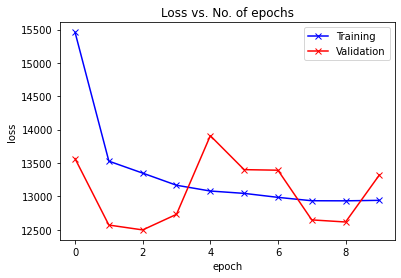

In [30]:
plot_losses(history)

2. **Train and Validation Losses after using `torch.transforms.normalize()` to normalize the image tensors**

After training the model for 10 epochs

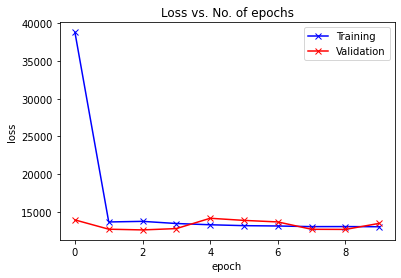

In [50]:
plot_losses(history)

After training the model for 30 epochs 

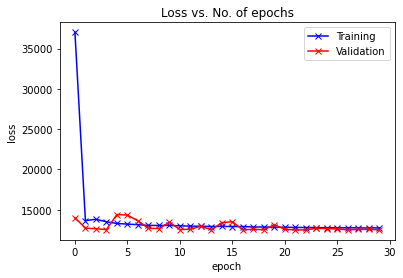

In [28]:
plot_losses(history)

3. **Train and Validation Losses after rotating the tensors using** `Torchvision.Transforms.functional.rotate()`

After training the model for 20 epochs

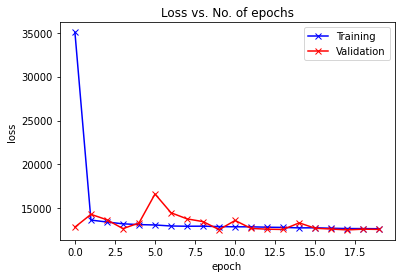

In [36]:
plot_losses(history)

4. **Train and Validation Losses after using weight decay and different learning rates**

The spikes show the training and validation losses when the learning rate was higher hence the best learning rate to consider while training this model is something around `1e-4`

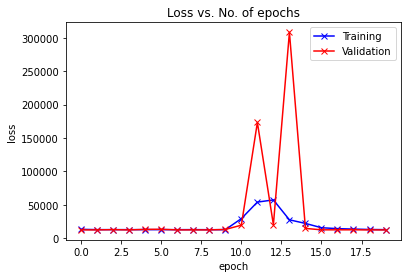

In [78]:
plot_losses(history)

In [79]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

The image below shows how the learning rate is varied per batch. This information helps us choose a better learning rate to train our model.

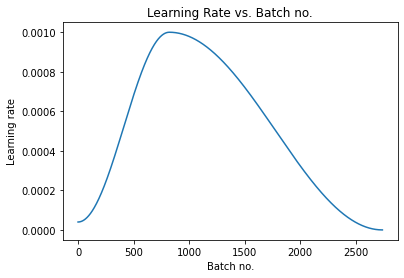

In [80]:
plot_lrs(history)

# **Making prediction on the Test Data**

Let's make some predictions on test data and see how well our model has trained.

In [40]:
test_data = MyDataset(test_df)

`make_predictions` return us the predicted values for all the test images and ground truth values of masses for the test images.

In [41]:
def make_predictions():
  ground_truth = []
  predicted_val =[]
  for i in range(len(test_data)):
    image, mass = test_data[i]
    xb = to_device(image.unsqueeze(0), device)
    yb = model(xb).item()
    ground_truth.append(mass)
    predicted_val.append(yb)
  return ground_truth, predicted_val


In [42]:
y, yhat = make_predictions()

I also imported the `sklearn.metric` module to check the `MSE` for the test data. As we can see the `MSE` is consistent with the `val_loss` for the validation data.

In [43]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_true = y, y_pred = yhat)
print(MSE)

12833.821317731215


I predicted the masses for one of the images and as obsereved the prediction is satisfactory.

In [39]:
img = torchvision.transforms.functional.to_tensor(test_df['images'][24521])
#plt.imshow(img, cmap='gray')
print("Expected Mass: {}".format(test_df['masses'][24521]))
xb = to_device(img.unsqueeze(0), device)
y = model(xb).item()
print("Predicted Mass: {}".format(y))



Expected Mass: 164.06967163085938
Predicted Mass: 189.7896728515625


# **Conclusion**



I tried different architectures and different data augmentation techniques to observe the `MSE` on validation data. Some of the different techniques that I used were

1. Performing Data Augmentation by divideing the image vectors by `255` which outputs a value between 0 and 1 for all the images.

2. Performing Data Augmentation by using `torchvision.transforms` for normalizing the grayscals images.

3. Using weight decay during training and varying the learning rate through out the training process.

I found out that the best losses are provided by the second technique that I used which was randomly rotaing the normalized image vectors by `90` degrees. This gave the validation `MSELoss` of `12,593`. Which is one of the best losses so far. 

I trained my model for varying amount of epochs, ranging from 10 to 30. I discovered that the best learning rate to train this model is around `1e-4`. 

I used `MSELoss` for the evaluation metric and the performance of the model is demonstrated in the graphs above. 

In the end, I would like to thank you for going through my notebook. I would love for any suggestions to make it better.



